# Soil Moisture Active Passive (SMAP) Level 4 Data demo
In this demo we are downloading data using Planet OS Package-API which let's us use bigger amount of data with less time than raster API. 
We are showing Portugal and Spain droughts what might have been a reason for over 600 wildfires that happend during summer and autumn 2017. Note that dates in the demo has changed and therefore description might not be relevant 

In [12]:
import time
import os
from package_api import download_data
import xarray as xr
from netCDF4 import Dataset, num2date
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import datetime
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [13]:
API_key = open('APIKEY').read().strip()

Here we define the area we are intrested, time range from where we want to have the data, dataset key to use and variable name.

In [14]:
def get_start_end(days):
    date = datetime.datetime.now() - datetime.timedelta(days=days)
    time_start = date.strftime('%Y-%m-%d') + 'T16:00:00'
    time_end = date.strftime('%Y-%m-%d') + 'T19:00:00'
    return time_start,time_end

In [15]:
latitude_south = 15.9; latitude_north = 69.5
longitude_west = -17.6; longitude_east = 38.6

area = 'europe'
days = 6
time_start,time_end = get_start_end(days)
dataset_key = 'nasa_smap_spl4smau'
variable = 'Analysis_Data__sm_surface_analysis'

This one here is generating working directory, we need it to know where we are going to save data. No worries, we will delete file after using it! 

In [16]:
folder = os.path.realpath('.') + '/'

Now we ara making a function for making images 

In [17]:
def make_image(lon,lat,data,date,latitude_north, latitude_south,longitude_west, longitude_east,unit,**kwargs):
    m = Basemap(projection='merc', lat_0 = 55, lon_0 = -4,
         resolution = 'i', area_thresh = 0.05,
         llcrnrlon=longitude_west, llcrnrlat=latitude_south,
         urcrnrlon=longitude_east, urcrnrlat=latitude_north)
    lons,lats = np.meshgrid(lon,lat)
    lonmap,latmap = m(lons,lats)
    
    if len(kwargs) > 0:
        fig=plt.figure(figsize=(10,8))
        plt.subplot(221)
        m.drawcoastlines()
        m.drawcountries()
        c = m.pcolormesh(lonmap,latmap,data,vmin = 0.01,vmax = 0.35)
        plt.title(date)
        
        plt.subplot(222)
        m.drawcoastlines()
        m.drawcountries()
        plt.title(kwargs['date_later'])
        m.pcolormesh(lonmap,latmap,kwargs['data_later'],vmin = 0.01,vmax = 0.35)
        
        
        
    else:
        fig=plt.figure(figsize=(9,7))
        m.drawcoastlines()
        m.drawcountries()
        c = m.pcolormesh(lonmap,latmap,data,vmin = 0.01,vmax = 0.35)
        plt.title(date)
    
    cbar = plt.colorbar(c)
    cbar.set_label(unit)
    plt.show()

Here we are downloading data by using Package-API. If you are intrested how data is downloaded, find the file named `package_api.py` from notebook folder.

In [18]:
try:
    package_key = download_data(folder,dataset_key,API_key,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,variable,area)
except:
    days = 7
    time_start,time_end = get_start_end(days)
    package_key = download_data(folder,dataset_key,API_key,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,variable,area)


https://api.planetos.com/v1/packages/nasa_smap_spl4smau_20191228T160000to20191228T190000_europe?apikey=8428878e4b944abeb84790e832c633fc
https://api.planetos.com/v1/packages/nasa_smap_spl4smau_20191227T160000to20191227T190000_europe?apikey=8428878e4b944abeb84790e832c633fc
Data is downloaded!


Now we have data and we are reading it in using xarray:

In [19]:
filename_europe = package_key + '.nc'
data = xr.open_dataset(filename_europe)
surface_soil_moisture_data = data.Analysis_Data__sm_surface_analysis
unit = surface_soil_moisture_data.units
surface_soil_moisture = data.Analysis_Data__sm_surface_analysis.values[0,:,:]
surface_soil_moisture = np.ma.masked_where(np.isnan(surface_soil_moisture),surface_soil_moisture)

latitude = data.lat; longitude = data.lon
lat = latitude.values
lon = longitude.values
date = str(data.time.values[0])[:-10]

/Users/etoodu/opt/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'Analysis_Data__sm_surface_analysis' has multiple fill values {-9999.0, 9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,


Here we are making image by using function defined above. 
In this image we can see how dry Iberian peninsula (Portugal and Spain) was during wildfires in October. On 15th October strong winds from the  Hurricane Ophelia quickly spread flames along the Iberian coast. We can see that on that day Iberian peninsula soil moisture was comparable with African deserts. 

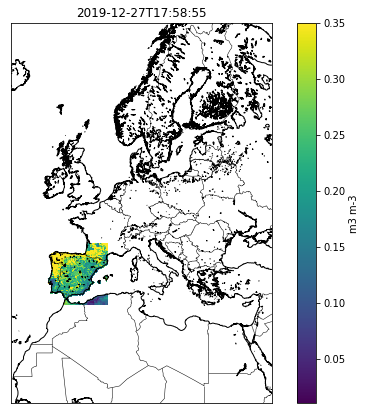

In [20]:
make_image(lon,lat,surface_soil_moisture,date,latitude_north, latitude_south,longitude_west, longitude_east,unit)

So let's see Portugal and Spain littlebit closer. For that we need to define the area and we will slice data from this area. 

In [21]:
iberia_west = -10; iberia_east = 3.3
iberia_south = 35; iberia_north = 45

lon_ib = longitude.sel(lon=slice(iberia_west,iberia_east)).values
lat_ib = latitude.sel(lat=slice(iberia_north,iberia_south)).values
soil_ib = surface_soil_moisture_data.sel(lat=slice(iberia_north,iberia_south),lon=slice(iberia_west,iberia_east)).values[0,:,:]
soil_ib = np.ma.masked_where(np.isnan(soil_ib),soil_ib)

Let's also import some data from later as well.

In [22]:
days2 = days -1
time_start, time_end = get_start_end(days2)
try:
    package_key_iberia = download_data(folder,dataset_key,API_key,iberia_west,iberia_east,iberia_south,iberia_north,time_start,time_end,variable,area)
except:
    days2 = days - 2
    time_start, time_end = get_start_end(days2)
    package_key_iberia = download_data(folder,dataset_key,API_key,iberia_west,iberia_east,iberia_south,iberia_north,time_start,time_end,variable,area)

filename_iberia = package_key_iberia + '.nc'
data_later = xr.open_dataset(filename_iberia)
soil_data_later = data_later.Analysis_Data__sm_surface_analysis
soil_later = data_later.Analysis_Data__sm_surface_analysis.values[0,:,:]
soil_later = np.ma.masked_where(np.isnan(soil_later),soil_later)

latitude_ib = data.lat; longitude_ib = data.lon
lat_ibl = latitude_ib.values
lon_ibl = longitude_ib.values
date_later = str(data_later.time.values[0])[:-10]

https://api.planetos.com/v1/packages/nasa_smap_spl4smau_20191228T160000to20191228T190000_europe?apikey=8428878e4b944abeb84790e832c633fc
https://api.planetos.com/v1/packages/nasa_smap_spl4smau_20191229T160000to20191229T190000_europe?apikey=8428878e4b944abeb84790e832c633fc
file already exists, no need to download other one


/Users/etoodu/opt/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'Analysis_Data__sm_surface_analysis' has multiple fill values {-9999.0, 9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,


Now we are making two images from the same area - Portugal and Spain. 
On the left image we can see soil moisture values on 15th October and on the right image we can see soil moisture on 21th October.

We can see that the land was getting littlebit wetter with a few days. It even helped firefighters to get wildfires under control. 

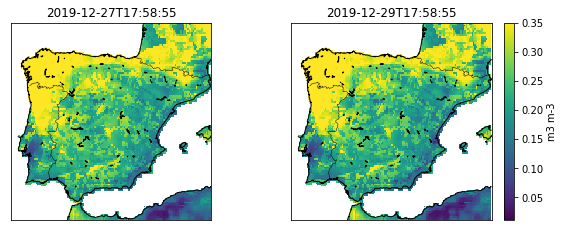

In [23]:
make_image(lon_ib,lat_ib,soil_ib,date,iberia_north, iberia_south,iberia_west, iberia_east, unit, data_later = soil_later,date_later = date_later)

Finally, let's delete files we downloaded:

In [24]:
if os.path.exists(filename_europe):
    os.remove(filename_europe)
if os.path.exists(filename_iberia):
    os.remove(filename_iberia)